In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
ine = pd.read_csv("../../data/raw/uslocs/banks_income_expense_final.csv")
basic = pd.read_csv("../../data/raw/uslocs/banks_basic_final.csv")

In [5]:
ine.head(1)

,Tag,Bank,2023-12-31,2023-09-30,2023-06-30,2023-03-31,2022-12-31,2022-09-30,2022-06-30,2022-03-31,...,2002-12-31,2001-12-31,2000-12-31,1999-12-31,1998-12-31,1997-12-31,1996-12-31,1995-12-31,1994-12-31,1993-12-31
0,Total charge-offs secured by 1-4 family reside...,jpmorgan-chase-bank,"$202,000,000","$127,000,000","$70,000,000","$17,000,000","$74,000,000","$64,000,000","$50,000,000","$29,000,000",...,"$48,000,000","$29,000,000","$45,000,000","$20,000,000","$21,000,000","$25,000,000","$26,000,000","$49,000,000","$64,000,000","$63,000,000"


In [6]:
def clean_vals(s):
    st = s[:]
    st = st.replace(",","").replace("$", "")
    i = int(st)
    return i

In [7]:
def date_to_qtr(date):
    yr = date[:4]
    q = date[5:7]
    if q == '12':
        qtr = 'Q4'
    if q == '09':
        qtr = 'Q3'
    if q == '06':
        qtr = 'Q2'
    if q == '03':
        qtr = 'Q1'    
    return (yr + " " + qtr)


## Projection Frameworks

In [8]:
cols = ine.columns[2:]
d2q = {col : date_to_qtr(col) for col in cols}
ine = ine.rename(columns=d2q)
cols = basic.columns[2:]
d2q = {col : date_to_qtr(col) for col in cols}
basic = basic.rename(columns=d2q)

In [9]:
tags = ['Net interest income', 'Total noninterest income', 'Total noninterest expense', 
        'Additional Noninterest Income', 'Additional noninterest expense', 
        'Pre-tax net operating income', 'Net gains (losses) on sales of loans', 'Securities gains (losses)',
        'Net gains (losses) on sales of other assets (excluding securities)', 'Provision for loan and lease losses',
        'Applicable income taxes', 'Minority interest net income']
#(ppnr) - pre-tax net income

In [10]:
bank = 'jpmorgan-chase-bank'
def get_lists(bank):
    lists = {}

    for idx, row in ine.iterrows():
        if row['Bank'] == bank:
            if  row['Tag'] in tags:
                lists[row["Tag"]] = row
    
    return lists
lists = get_lists(bank)

In [11]:
len(lists)
qtrs = lists['Net interest income'].keys()[2:]

In [12]:
lists["Total noninterest expense"][qtrs[0]]

'$78,648,000,000'

#### PPNR - Pre Provision Net Revenue

In [44]:
netIntInc = [clean_vals(x) for x in lists['Net interest income'][2:]]
nonIntInc = [clean_vals(x) for x in lists['Total noninterest income'][2:]]
nonIntExp = [clean_vals(x) for x in lists['Total noninterest expense'][2:]]
addNonIntInc = [clean_vals(x) for x in lists['Additional Noninterest Income'][2:]]
addNonIntExp = [clean_vals(x) for x in lists['Additional noninterest expense'][2:]]
# doesnt have losses projected for operational risk

In [45]:
ppnr = [netIntInc[i] + nonIntInc[i] + addNonIntInc[i] - nonIntExp[i] - addNonIntExp[i] for i in range(len(qtrs))]
#list of ppnr for each qtr : zip with qtrs

In [46]:
len(ppnr) == len(qtrs) #sanity check - for my sanity:)

True

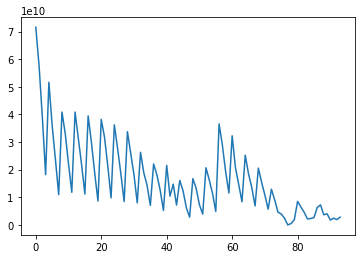

In [47]:
plt.plot(ppnr)

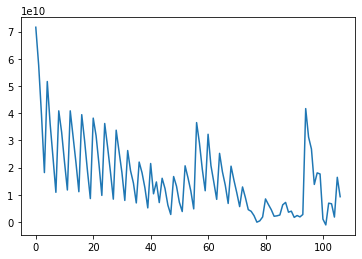

In [48]:
l = [41681999291.53735,
 31209000497.919373,
 26821251457.67676,
 13803999063.700428,
 18049499621.140976,
 17646249122.13179,
 1053750078.5932407,
 -1077000446.9634,
 6918750213.099222,
 6691249795.1120205,
 1811749468.389719,
 16425248822.747786,
 9295749271.30634]
for x in l:
    ppnr.append(x)
plt.plot(ppnr)

In [49]:
ni = [49951999602.046455,
 35166250685.66068,
 26561750979.769695,
 18663999248.243515,
 29025999302.891914,
 37430998700.9759,
 19769749537.550755,
 19769749537.550755,
 16585749469.132584,
 8680750186.82653,
 7023499976.879406,
 13116749974.518147,
 9160750099.151915]
for x in ni:
    netIntInc.append(x)

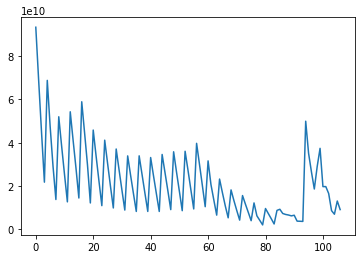

In [50]:
plt.plot(netIntInc)

#### Pre Tax Net Income

In [14]:
def loss_from_gnl(gnl):
    
    losses = [] 
    for x in gnl:
        if x < 0:
            loss = x
        if x >= 0:
            loss = 0
        losses.append(loss)
    return losses

In [15]:
#DRY
preTaxOperInc = [clean_vals(x) for x in lists['Pre-tax net operating income'][2:]]
loanProvisions = [clean_vals(x) for x in lists['Provision for loan and lease losses'][2:]]
creditGnL = [clean_vals(x) for x in lists['Net gains (losses) on sales of loans'][2:]] # has both gains, losses
creditLosses = loss_from_gnl(creditGnL)
secGnL = [clean_vals(x) for x in lists['Securities gains (losses)'][2:]]
securityLosses = loss_from_gnl(secGnL)
otherGnL = [clean_vals(x) for x in lists['Net gains (losses) on sales of other assets (excluding securities)'][2:]]
otherLosses = loss_from_gnl(otherGnL)

In [16]:
#ptni = ppnr+pretaxoper - credl - secL - trading/counterparty losses
# not sure if ptni takes only provisions for losses or losses themselves
ptni = [ppnr[i] + preTaxOperInc[i] - loanProvisions[i] - creditLosses[i] - securityLosses[i] - otherLosses[i] for i in range(len(qtrs))]
len(ptni) == len(qtrs)

True

In [30]:
incomeTax =[clean_vals(x) for x in lists['Applicable income taxes'][2:]]
lists['Minority interest net income'][2:] = lists['Minority interest net income'][2:].fillna("$0")
minorityInt = [clean_vals(x) for x in lists['Minority interest net income'][2:] if x != 'NaN'] # -ve to +ve, vice versa
minorityIntNetInc = []
for x in minorityInt:
    if x < 0:
        loss = abs(x)
    if x >= 0:
        loss = -x
    minorityIntNetInc.append(loss)

In [31]:
atinc = [ptni[i] - incomeTax[i] - minorityIntNetInc[i] for i in range(len(qtrs))]
# after tax income

In [ ]:
# now ppnr and ptni, also atinc if needed can be preojected over a frame, with macro vars 
#- > prj components first, then calc ptni etc

## Net Charge-offs Approach
Projecting losses over a horizon

*The net charge-off approach projects losses over the projection horizon using models that capture
the historical behavior of net charge-offs as a function of macroeconomic and financial market conditions and loan portfolio characteristics. The Federal Reserve models losses under the net
charge-off approach for other consumer loans, business and corporate credit card loans, smallbusiness loans, student loans, and international retail loans.*

>the FRB usually uses 13 quarters for the projection horizon

In [ ]:
# we have percentages:')

## Projections

In [32]:
"""Now, in projecting ppnr, we can use a more granular method, wherein we project about 21-24 different 
variables that make up the components of ppnr, but we will go with the mid-lecel component projections
Loss: no normalisation
FRB says it uses autoregressive models:')"""

'Now, in projecting ppnr, we can use a more granular method, wherein we project about 21-24 different \nvariables that make up the components of ppnr, but we will go with the mid-lecel component projections'

In [ ]:
# According to FRB the key macroeconomic regressors for ppnr:
"""
BBB corporate yield
5-year Treasury yield 
Market Volatility Index
Real GDP growth
10-year Treasury yield
3-month Treasury rate
Unemployment rate
"""

In [ ]:
# statsmodel - AutoReg 
# arima
# do only ppnr - for 1 bank, project for the 5 vars, then recalc ppnr for each qtr, 
#then do losses over proj horizon - 13 qtrs: ie.,
#  (i m thinking) sum (supervisory)(what should have been) - sum(adeverse)

In [1]:
"""
Accuuracy Scores, metrics, charts, interactive querying
Compare models - scenario - regression; risk - credit risk, time series for macrovars

"""

'Accuuracy Scores'

1) Time Series projection for macrovars
2) Use that for loss calculations
3) Make charts - ppnr(add projected vals to actul vals, for ppnr and components and plot)
4) Viz - corr matrix, line graphs per component, time series- macro
5) Risk  - all banks over years df
6) viz risk
7) compliance df, viz
8) Credit risk data, enrichment, modelling
8) Backtest
10) Aggregate data insights - like mean, sd, var

1) Macrovars chart
2) risk - liquidity
 - quick ratio, current ratio - for all banks df(give filter option)
 - 

3) Stress tests 
Regression: metrics
Results:
- Corr plots - line for each cmponent
- corr heat map - per bank
- ppnr and component charts, numbers - per bank

4) Compliance
- credit ratios - plot - for all banks - filter - there are only 2
- so maybe give CAR also, 
- give interactive option that will retrieve compliance